In [1]:
import os
import numpy as np
from scipy.stats import multivariate_normal
import matplotlib.pyplot as plt
from matplotlib import patches
from matplotlib import lines
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from matplotlib.colors import LinearSegmentedColormap

os.sys.path.append('../data/scripts/')
os.sys.path.append('../evaluation/')
from create_training_data_lib import random_mixture_sample, correlation_to_covariance, plot_cov_ellipse


In [2]:
# plot parameters
lims = [-2, 2]


In [3]:
# function for creating a custom color map
def get_custom_cmap(name, max_alpha=1.0):
    base_cmap = plt.get_cmap(name)
    n = 256  # Number of discrete colors
    max_alpha = np.min([1, max_alpha])
    alphas = np.linspace(0, max_alpha, n)
    custom_cmap = LinearSegmentedColormap.from_list(
        'custom_cmap',
        [(base_cmap(i / n)[:3] + (alphas[i],)) for i in range(n)],
        N=n
    )
    return custom_cmap


In [4]:
def get_sample():
    """ Wrapper for random_mixture_sample
        Generates a random Gaussian mixture
    """
    # sample random mixture
    sample, mean_vectors, std_devs, corr_mats, _, _ = random_mixture_sample(
        n_dimensions = 2,
        n_components = 2,
        n_samples = 3000,
        p_frac_range = [0.3, 0.3],
        quantize_step = np.random.choice([0, 0.05, 0.1, 0.2]),
    )
    cov_mats = [correlation_to_covariance(i,j) for i,j in zip(corr_mats, std_devs)]

    # standardize
    a = 1/sample.std(axis=0) # reciprocal of sample std for scaling
    b = -sample.mean(axis=0) # negative of sample mean for shifting
    std_devs = [i*a for i in std_devs]
    mean_vectors = [a*(i+b) for i in mean_vectors]
    sample = (sample+b)*a
    del a, b
    
    # calculate cov mats
    cov_mats = [correlation_to_covariance(i,j) for i,j in zip(corr_mats, std_devs)]
    
    return sample, mean_vectors, cov_mats

def plot_mixture_sample(ax, means, covs, plot_path=True):
    """ Visualizes Gaussian mixture of reference and pathological components
        Adds them to a specified them axis
    """
    # define grid for plotting pdf heat map
    x_grid, y_grid = np.mgrid[lims[0] : lims[1] : 100j, lims[0] : lims[1] : 100j,]
    positions = np.vstack([x_grid.ravel(), y_grid.ravel()]).T
    colors_ellipses = ['blue', 'red', 'red']

    # loop components and plot pdfs
    for i in range(len(means)-1, -1, -1):
        
        if not plot_path:
            if i>0:
                continue
                
        pdf = multivariate_normal(means[i], covs[i]).pdf(positions).reshape(x_grid.shape)
        pdf = (pdf-pdf.min())/(pdf.max()-pdf.min())
        pdf[pdf<=0.01] = np.nan  # no color for very low probability
        
        if i==0:
            ax.pcolormesh(x_grid, y_grid, pdf, cmap=get_custom_cmap('Blues'))
        else:
            ax.pcolormesh(x_grid, y_grid, pdf, cmap=get_custom_cmap('Reds', 0.7))
#             ax.contour(x_grid, y_grid, pdf, levels=5, cmap='Reds', alpha=0.5)

samples = []
means = []
covs = []
nplots = 4
for i in range(nplots):
    result = get_sample()
    samples.append(result[0])
    means.append(result[1])
    covs.append(result[2])
    
#     # maybe plot
#     plt.figure()
#     ax = plt.subplot()
#     plot_mixture_sample(ax, means[-1], covs[-1])
    

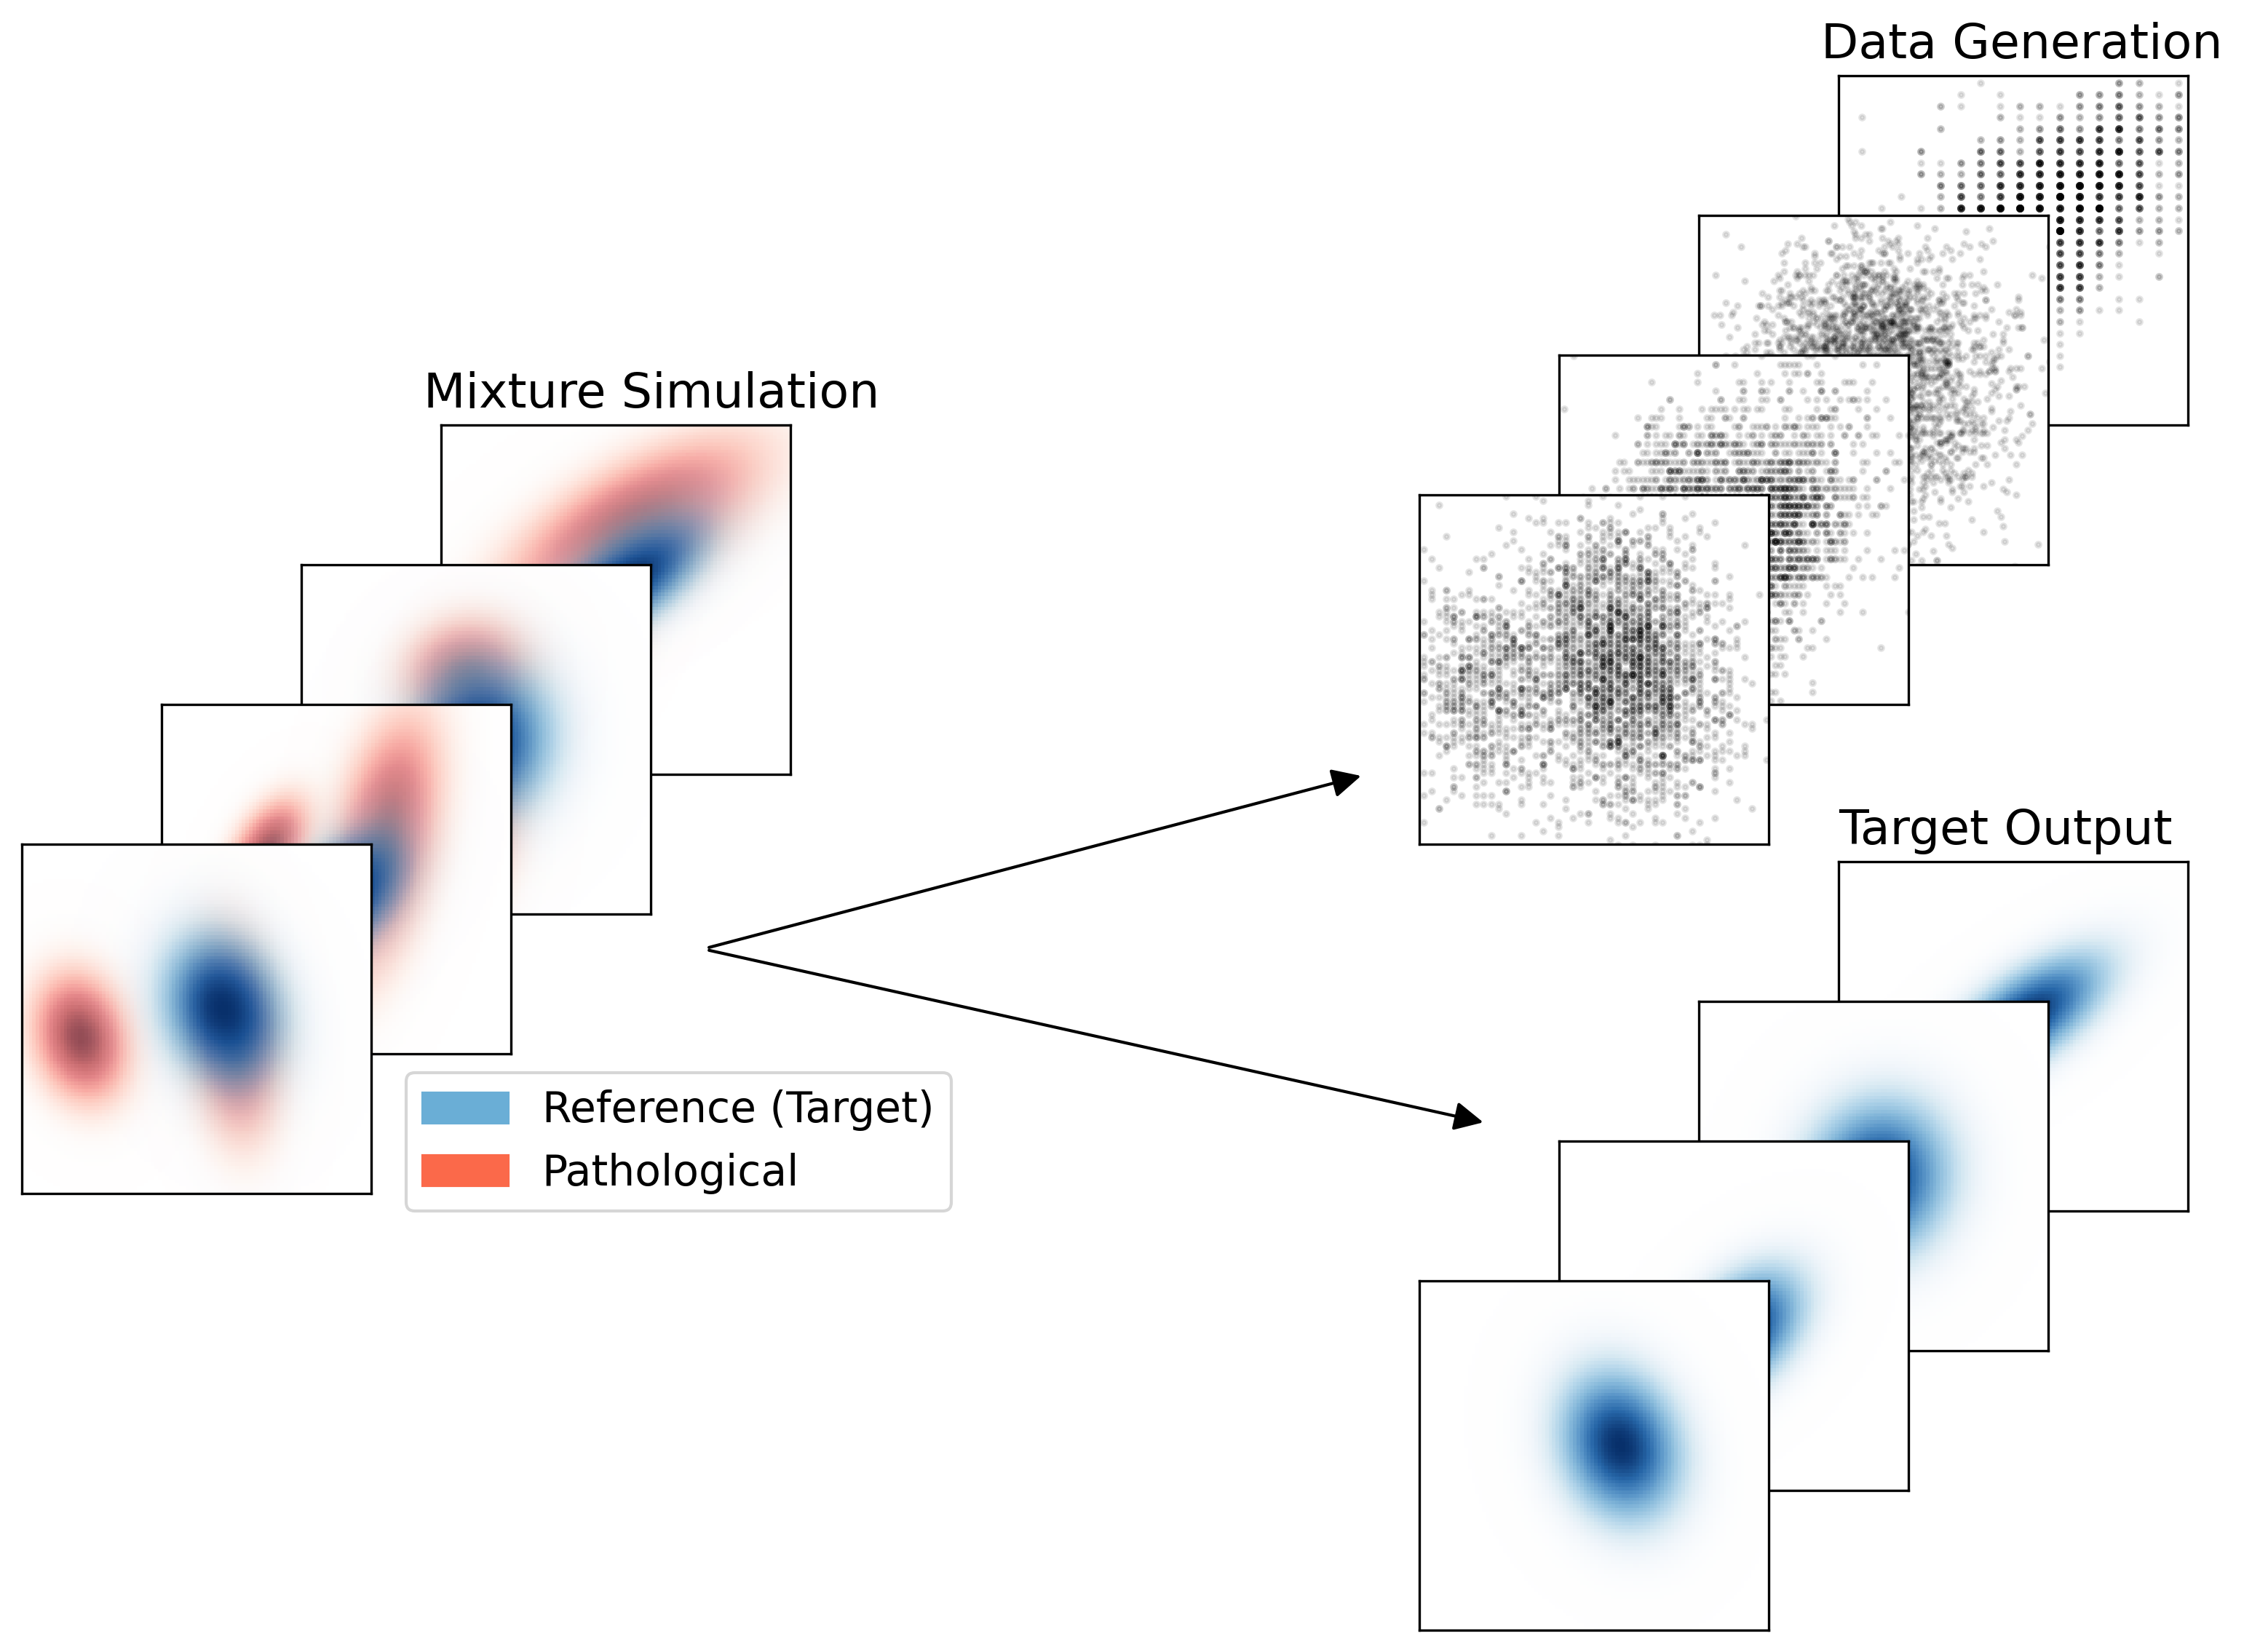

In [5]:
# Create a main figure
fig, ax = plt.subplots(figsize=(8, 8), dpi=300)
ax.axis('off')  # Turn off the main axes

# Define positions for the three corners of a triangle
positions = [
    (0.1, 0.5),  # Left center
    (0.9, 0.7),  # Right top
    (0.9, 0.25),  # Right bottom
]

# Create three stacks of plots
shift = 0.08
for i, (x, y) in enumerate(positions):
    for j in range(nplots):  # Adjust the range for more or fewer images in each stack
        # Create inset axes for each plot
        ax_inset = fig.add_axes([x - j*shift, y - j*shift, 0.2, 0.2], 
                                transform=ax.transAxes)
        
        if i==0: # plot mixture sample
            plot_mixture_sample(ax_inset, means[j], covs[j])
            if j==0:
                # legend
                ax_inset.add_patch(patches.Rectangle((0, 0), 0, 0, color=get_custom_cmap('Blues')(0.5), alpha=1, label='Reference (Target)'))
                ax_inset.add_patch(patches.Rectangle((0, 0), 0, 0, color=get_custom_cmap('Reds')(0.5), alpha=1, label='Pathological'))
#                 ax_inset.add_line(lines.Line2D([0, 0], [0, 0], color=plt.get_cmap('Reds')(0.7), alpha=0.6, label='Pathological'))
                ax_inset.legend(loc=(-0.1, -1.25), fontsize=14)

        elif i==1: # data scatter plot
            ax_inset.scatter(samples[j][:,0], samples[j][:,1], s=10, marker='.', c='k', alpha=0.1)
            ax_inset.set_xlim(lims)
            ax_inset.set_ylim(lims)
        elif i==2:
            plot_mixture_sample(ax_inset, means[j], covs[j], plot_path=False)
        
        ax_inset.set_xticks([])
        ax_inset.set_yticks([])

# arrows
arrow = patches.FancyArrowPatch(
    (positions[0][0]+0.15, 0.4), (positions[1][0]-0.27, 0.5), 
    transform=fig.transFigure, color='black',
    arrowstyle='-|>', mutation_scale=20)
fig.patches.append(arrow)
arrow = patches.FancyArrowPatch(
    (positions[0][0]+0.15, 0.4), (positions[1][0]-0.2, 0.3), 
    transform=fig.transFigure, color='black', 
    arrowstyle='-|>', mutation_scale=20)
fig.patches.append(arrow)

# labels
fig.text(positions[0][0]-0.01, positions[0][1]+0.21, 'Mixture Simulation', c='k', fontsize=16)
fig.text(positions[1][0]-0.01, positions[1][1]+0.21, 'Data Generation', c='k', fontsize=16)
fig.text(positions[2][0], positions[2][1]+0.21, 'Target Output', c='k', fontsize=16)

plt.show()
